# Barnard's Star

In [1]:
import wobble
import matplotlib.pyplot as plt
import numpy as np

/Users/mbedell/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
starid = 'barnards'
results = wobble.Results(filename='../results/results_'+starid+'_Kstar0_Kt0.hdf5')

Results: reading from ../results/results_barnards_Kstar0_Kt0.hdf5


In [3]:
rvs = results.star_time_rvs + results.bervs

In [4]:
sigs = np.ones_like(rvs) # HACK

In [5]:
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [6]:
coord = SkyCoord(ra=269.4486, dec=4.7379807, unit=(u.degree, u.degree), frame='icrs')
width = u.Quantity(0.01, u.degree)
height = u.Quantity(0.01, u.degree)
r = Gaia.query_object_async(coordinate=coord, width=width, height=height);

Query finished.


In [7]:
star = r[r['source_id'] == 4472832130942575872]

In [8]:
star

dist,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url
,,,,,yr,deg,mas,deg,mas,mas,mas,,mas.yr**-1,mas.yr**-1,mas.yr**-1,mas.yr**-1,,,,,,,,,,,,,,,,,mas,,,,mas**-2,um**-1,um**-1,,,,mas,,,,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,,mag,mag,mag,km.s**-1,km.s**-1,,K,log(cm.s**-2),'dex',,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,Rsun,Rsun,Rsun,Lsun,Lsun,Lsun,,
float64,int64,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int32,int16,bool,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,int32,float32,float32,float32,object,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,object,object
9.824740043517057e-06,1635721458409799680,Gaia DR2 4472832130942575872,4472832130942575872,533956466,2015.5,269.4486143580427,0.2228992191335898,4.737980765585507,0.3041988228146539,547.4506196448664,0.2899012145732713,1888.404,-802.802647878488,0.6378680351986493,10362.542163273869,0.3596168573247809,-0.75674546,0.7358516,-0.9222494,0.7776804,-0.941183,0.88051504,-0.92702585,-0.8647782,0.8366835,-0.8657498,80,80,78,2,11.204291,307.5757,0.13814884838845484,4.04820577977616,31,True,27.652666,1.2482400209573905,0.031582565659274885,-0.082077704,9,6,0.4152302,0,10,False,80,9938112.844575606,18292.003707963897,543.30365,8.195106,8,1645887.1906748712,4685.221151147555,351.2934,9.810388,9,13086427.844073331,22496.555096104148,581.70807,6.969867,1.4824057,1,2.8405204,1.615282,1.2252383,--,--,0,--,--,--,NOT_AVAILABLE,31.048145299980042,14.085855172346392,269.37664432873515,28.176068535639537,100002,3699.35,3316.327,4086.9048,0.301,0.0354,0.515,0.183,0.0349,0.2841,--,--,--,--,--,--,--,http://geadata.esac.esa.int/data-server/datalink/links?ID=4472832130942575872,--


In [9]:
rv_gaia = -110.51 * u.km / u.s # from Gaia DR2 docs

In [11]:
from astropy.time import Time
coord = SkyCoord(ra=star['ra'][0] * u.degree, 
                 dec=star['dec'][0] * u.degree, 
                 distance=1./star['parallax'][0] * u.kpc,
                 pm_ra_cosdec=star['pmra'][0] * u.mas / u.year,
                 pm_dec=star['pmdec'][0] * u.mas / u.year,
                 radial_velocity=rv_gaia,  
                 obstime=Time(star['ref_epoch'][0], format='decimalyear'),
                 frame='icrs')

In [12]:
dates = Time(results.dates, format='jd')

In [13]:
from tqdm import tqdm
rv_predicted = [coord.apply_space_motion(d).radial_velocity.value for d in tqdm(dates)]

100%|██████████| 306/306 [00:06<00:00, 50.12it/s]


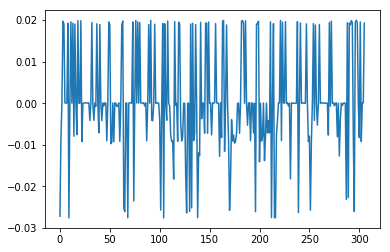

In [14]:
plt.plot(rv_predicted - np.median(rv_predicted))

In [15]:
pm = np.sqrt(star['pmra'][0]**2 + star['pmdec'][0]**2)
pm = (pm * u.mas / u.yr).to(u.arcsec / u.yr)
pm

<Quantity 10.39359284 arcsec / yr>

In [16]:
dist = (1./star['parallax'][0] * u.kpc).to(u.pc)
dist

<Quantity 1.82664877 pc>

In [17]:
vt = (4.74 * dist * pm).value * u.km / u.s # decompose doesn't work here

In [18]:
min_dist = dist/np.sqrt(1. + rv_gaia**2/vt**2)

In [19]:
min_dist

<Quantity 1.1534272 pc>

In [20]:
v = np.sqrt(rv_gaia**2 + vt**2)
v

<Quantity 142.51610656 km / s>

In [21]:
obstime = Time(star['ref_epoch'][0], format='decimalyear')
min_dist_time = obstime + np.sqrt(dist**2 - min_dist**2)/v
min_dist_time

<Time object: scale='utc' format='decimalyear' value=11733.663076714602>

In [22]:
def rv(date):
    t = (date - min_dist_time).jd * u.day # now relative to time of closest approach
    x = v**2 * t/np.sqrt(v**2 * t**2 + min_dist**2)
    return x.to(u.m / u.s)

def drv_dt(date):
    t = (date - min_dist_time).jd * u.day # now relative to time of closest approach
    x = v**2/np.sqrt(v**2 * t**2 + min_dist**2) - v**4 * t**2/(v**2 * t**2 + min_dist**2)**(3./2)
    return x.to(u.m / u.s / u.yr)

In [23]:
date = dates[0]
t = (date - min_dist_time).jd * u.day
x = v**2 * t/np.sqrt(v**2 * t**2 + min_dist**2)
x.to(u.m / u.s)
rv(dates[20])

<Quantity -110519.75905052 m / s>

In [24]:
predicted_rvs = np.array([rv(d).value for d in dates])

In [25]:
pipeline_rvs = results.pipeline_rvs + results.bervs

In [26]:
post_upgrade = results.dates >= 2457174.5 # June 2015
pre_upgrade = results.dates < 2457174.5

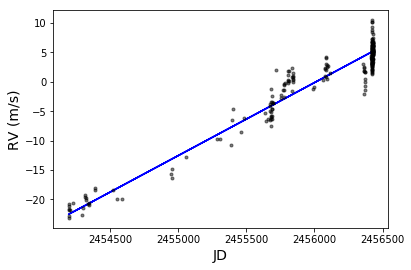

In [27]:
plt.plot(results.dates[pre_upgrade], predicted_rvs[pre_upgrade] - np.mean(predicted_rvs[pre_upgrade]), c='b')
plt.plot(results.dates[pre_upgrade], rvs[pre_upgrade] - np.mean(rvs[pre_upgrade]), 'k.', alpha=0.5)
plt.xlabel('JD', fontsize=14)
plt.ylabel('RV (m/s)', fontsize=14);
#plt.plot(results.dates[post_upgrade], rvs[post_upgrade] - np.mean(rvs[post_upgrade]), 'k.', alpha=0.5);
#plt.plot(results.dates[pre_upgrade], pipeline_rvs[pre_upgrade] - np.mean(pipeline_rvs[pre_upgrade]), 'r.', alpha=0.5);

In [28]:
wobble_resids = rvs[pre_upgrade] - predicted_rvs[pre_upgrade]
wobble_resids -= np.median(wobble_resids)
pipeline_resids = pipeline_rvs[pre_upgrade] - predicted_rvs[pre_upgrade]
pipeline_resids -= np.median(pipeline_resids)

wobble_resids_post = rvs[post_upgrade] - predicted_rvs[post_upgrade]
wobble_resids_post -= np.median(wobble_resids_post)
pipeline_resids_post = pipeline_rvs[post_upgrade] - predicted_rvs[post_upgrade]
pipeline_resids_post -= np.median(pipeline_resids_post)

In [29]:
wobble_rms = np.sqrt(np.std(wobble_resids)**2 + np.std(wobble_resids_post)**2)
pipeline_rms = np.sqrt(np.std(pipeline_resids)**2 + np.std(pipeline_resids_post)**2)

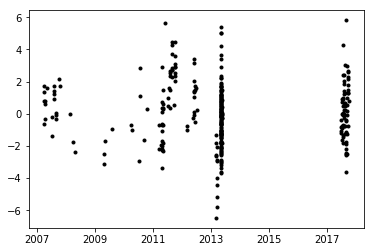

In [30]:
plt.plot_date(dates.plot_date[pre_upgrade], wobble_resids, 'k.')
plt.plot_date(dates.plot_date[post_upgrade], wobble_resids_post, 'k.');

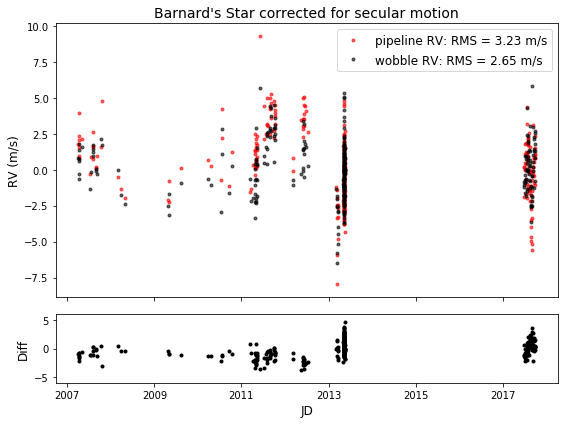

In [31]:
fig, (ax, ax2) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[4, 1]}, figsize=(8,6), sharex=True)
ax.plot_date(dates.plot_date[pre_upgrade], pipeline_resids, 'r.', alpha=0.6, 
             label='pipeline RV: RMS = {0:.2f} m/s'.format(pipeline_rms))
ax.plot_date(dates.plot_date[pre_upgrade], wobble_resids, 'k.', alpha=0.6, 
             label='wobble RV: RMS = {0:.2f} m/s'.format(wobble_rms))
ax.plot_date(dates.plot_date[post_upgrade], pipeline_resids_post, 'r.', alpha=0.6)
ax.plot_date(dates.plot_date[post_upgrade], wobble_resids_post, 'k.', alpha=0.6)
ax.set_title('Barnard\'s Star corrected for secular motion', fontsize=14)
ax.set_ylabel('RV (m/s)', fontsize=12)
ax2.set_xlabel('JD', fontsize=12)
ax2.plot_date(dates.plot_date[pre_upgrade], wobble_resids - pipeline_resids, 'k.')
ax2.plot_date(dates.plot_date[post_upgrade], wobble_resids_post - pipeline_resids_post, 'k.')
ax2.set_ylabel('Diff', fontsize=12)
ax2.set_ylim([-6,6])
ax.legend(fontsize=12)
fig.tight_layout();

In [32]:
from astropy.stats import LombScargle
ls = LombScargle(results.dates[pre_upgrade], wobble_resids)
frequency, power = ls.autopower()

In [33]:
probabilities = [0.05, 0.01, 0.001]
pow_5, pow_1, pow_01 = ls.false_alarm_level(probabilities) 

In [ ]:
plt.plot(1./frequency, power, c='k')
#plt.axhline(pow_5, c='r', ls='-.')
#plt.axhline(pow_1, c='r', ls=':')
#plt.axhline(pow_01, c='r', ls='--')
plt.xscale('log')
plt.xlabel('Period (d)', fontsize=14);